In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [1]:
import pathlib

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" # url지정 . tgz

In [7]:
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar = True ) # 맨처음 파라미터가 그냥 이름이 아니라 거기의 파일 이름이다. 

228818944/228813984 [==============================] - 1s 0us/step


In [8]:
data_dir = pathlib.Path(data_dir)
image_count =len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


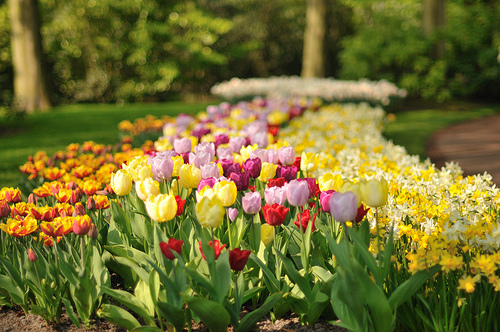

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(f"{tulips[1]}")

In [12]:
#하이퍼 파라미터 - 사용자가 조정하는 파라미터 
image_height = 180
image_width = 180
batch_size = 64
lr = 1e-3
! ls -la


total 16
drwxr-xr-x 1 root root 4096 Nov  6 17:30 .
drwxr-xr-x 1 root root 4096 Nov 16 05:50 ..
drwxr-xr-x 1 root root 4096 Nov  6 17:30 .config
drwxr-xr-x 1 root root 4096 Nov  6 17:30 sample_data


In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split = 0.2,
    subset = 'training',
    seed = 1234, 
    image_size = (image_height, image_width),
    batch_size = batch_size
    
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split = 0.2,
      subset = 'validation',
      seed = 1234,
      image_size = (image_height, image_width),
      batch_size = batch_size

)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


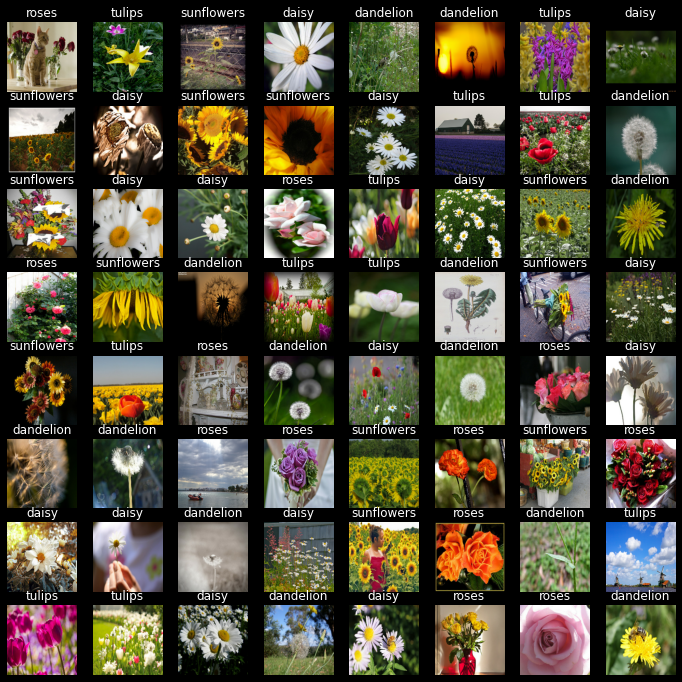

In [19]:
plt.style.use('dark_background')
plt.figure(figsize=  (12,12))
for img, label in train_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(img[i].numpy().astype('uint8'))  # plt로 출력하기 위해서는 numpy여야 하고, 0~255사이 여야함(uint8)
    plt.title(class_names[label[i]])
    plt.axis('off')

In [25]:
for x_batch, y_batch in train_ds:
  print(x_batch.shape)
  print(x_batch.numpy().shape)
  print(y_batch.shape)
  break
# batch_size, height, width, channel 순서인듯.  batch_size = 64이므로 64개씩 들어간 것 , rgb3채널 컬러영상 

(64, 180, 180, 3)
(64, 180, 180, 3)
(64,)


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [28]:
norm_layers=  layers.experimental.preprocessing.Rescaling(1.0/255.0) # 정규화 
normalized_ds = train_ds.map(lambda x,y :(norm_layers(x),y))  

In [29]:
#dataloader
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [30]:
#fully connected layer만들기 전에 알아둘 것. 
num_class = len(class_names)
print(num_class)


5


In [33]:
def model_ops():
  #convolutional하게 만든다. 
  model = Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape = (image_height, image_width, 3)),
  layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
  layers.MaxPool2D(),

  layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
  layers.MaxPool2D(),
  
  layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
  layers.MaxPool2D(),

  layers.Dropout(rate= 0.15),
  layers.Flatten(),
  layers.Dense(128,activation = 'relu'),
  layers.Dense(num_class)
  ])

  return model

In [36]:
model = model_ops()
optim = keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)# 분류기 때문에 cross entropy. 2개아니고 더 많아도 사용가능. 
model.compile(optimizer = 'adam', loss=  loss_fn, metrics = ['accuracy'])
model.summary()
#parameter1의 개수 : 3x3x3 x 16 + 16 = 448 
#parameter2의 개수 : 3x3x16 x 32 + 32 = 4640 
#parameter3의 개수 : 3x3x32x64 + 64(convolution하나당 1개의 bias만 필요.) = 18496
#22,22,64 >flatten> 22*22*64 = 30976
# 마지막직전 fully connected layer : 30976*128+128   = 3965056 
# 마지막 128>5  128*5+5 = 645 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [37]:
# training model 
epochs = 10
history = model.fit(train_ds, validation_data=  val_ds, epochs = epochs)

Epoch 1/10
46/46 [==============================] - 3s 63ms/step - loss: 1.4057 - accuracy: 0.3856 - val_loss: 1.1965 - val_accuracy: 0.4768
Epoch 2/10
46/46 [==============================] - 1s 25ms/step - loss: 1.0760 - accuracy: 0.5630 - val_loss: 1.0189 - val_accuracy: 0.6158
Epoch 3/10
46/46 [==============================] - 1s 25ms/step - loss: 0.9187 - accuracy: 0.6366 - val_loss: 0.9494 - val_accuracy: 0.6158
Epoch 4/10
46/46 [==============================] - 1s 25ms/step - loss: 0.7927 - accuracy: 0.6911 - val_loss: 0.9311 - val_accuracy: 0.6390
Epoch 5/10
46/46 [==============================] - 1s 25ms/step - loss: 0.6554 - accuracy: 0.7575 - val_loss: 0.8798 - val_accuracy: 0.6744
Epoch 6/10
46/46 [==============================] - 1s 25ms/step - loss: 0.5848 - accuracy: 0.7807 - val_loss: 0.8924 - val_accuracy: 0.6621
Epoch 7/10
46/46 [==============================] - 1s 25ms/step - loss: 0.3967 - accuracy: 0.8621 - val_loss: 0.8910 - val_accuracy: 0.7207
Epoch 8/10
46

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
acc =history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=  history.history['loss']
val_loss=  history.history['val_loss']

epochs_range  = range(epochs)

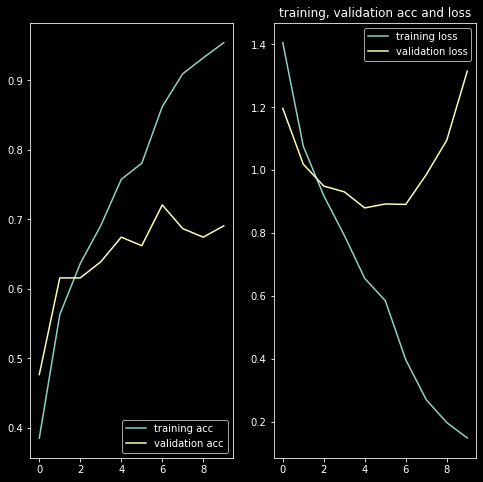

In [44]:
#accuracy 그래프

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,  acc, label = 'training acc')
plt.plot(epochs_range, val_acc, label = 'validation acc')
plt.legend(loc = 'lower right')

#loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'training loss')
plt.plot(epochs_range, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('training, validation acc and loss')
plt.show()

#그래프를 보면 알 수 있듯이, 그리 좋지 않은 모델, epoch수를 늘리던가 등등의 hyper parameter 조정이 필요해 보인다. 

In [46]:
# data augmentation (transformation)
import keras.layers.experimental.preprocessing as ep # 아까 위에서 많이 써서 줄이기 위해 이렇게 한번에 함. 
data_augmentation = keras.Sequential([
            ep.RandomFlip('horizontal', input_shape = (image_height, image_width,3)),
            ep.RandomRotation(0.15),
            ep.RandomZoom(0.1)
])

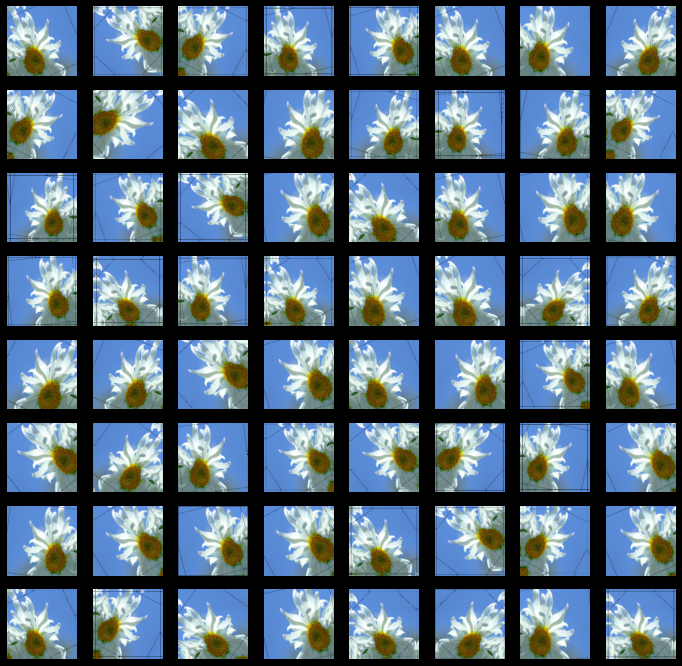

In [48]:
plt.figure(figsize = (12,12))

cnt = 0

for images, labels in train_ds.take(1):
  for i in range(64):
    aug_images = data_augmentation(images)
    ax = plt.subplot(8,8, i+1)
    plt.imshow(aug_images[6].numpy().astype('uint8'))
    plt.axis('off')

In [54]:
#Batch normalization

def model_ops2():
  #convolutional model  - 위의 것과 같지만, 앞에 data_augmentation과정이 추가된 것으로, 익숙해질겸 한번 더 적어본다.
  model = Sequential([
        data_augmentation, 
        layers.experimental.preprocessing.Rescaling(1.0/255.0),
        layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
        layers.MaxPool2D(),
        layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
        layers.MaxPool2D(),
        layers.Conv2D(64,3,padding = 'same', activation = 'relu'),
        layers.MaxPool2D(),
        layers.Dropout(rate = 0.2),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(num_class)

  ]) 
  return model


In [64]:
model2 = model_ops2()
loss_fn =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)#클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값), 그렇지 않으면 from_logits = True.
model2.compile(optimizer = 'adam', loss = loss_fn, metrics = ['accuracy'])

In [65]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 45, 45, 64)       

In [66]:
epoch = 20
history = model2.fit(train_ds, validation_data = val_ds, epochs = epoch)

Epoch 1/20
46/46 [==============================] - 2s 34ms/step - loss: 1.5406 - accuracy: 0.3147 - val_loss: 1.3010 - val_accuracy: 0.4510
Epoch 2/20
46/46 [==============================] - 1s 32ms/step - loss: 1.1364 - accuracy: 0.5320 - val_loss: 1.1427 - val_accuracy: 0.5313
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 1.0240 - accuracy: 0.5882 - val_loss: 1.0854 - val_accuracy: 0.5749
Epoch 4/20
46/46 [==============================] - 1s 32ms/step - loss: 0.9670 - accuracy: 0.6216 - val_loss: 0.9950 - val_accuracy: 0.6322
Epoch 5/20
46/46 [==============================] - 1s 32ms/step - loss: 0.9226 - accuracy: 0.6325 - val_loss: 0.8673 - val_accuracy: 0.6567
Epoch 6/20
46/46 [==============================] - 2s 33ms/step - loss: 0.8778 - accuracy: 0.6560 - val_loss: 0.8648 - val_accuracy: 0.6662
Epoch 7/20
46/46 [==============================] - 2s 33ms/step - loss: 0.8266 - accuracy: 0.6822 - val_loss: 0.8389 - val_accuracy: 0.6812
Epoch 8/20
46

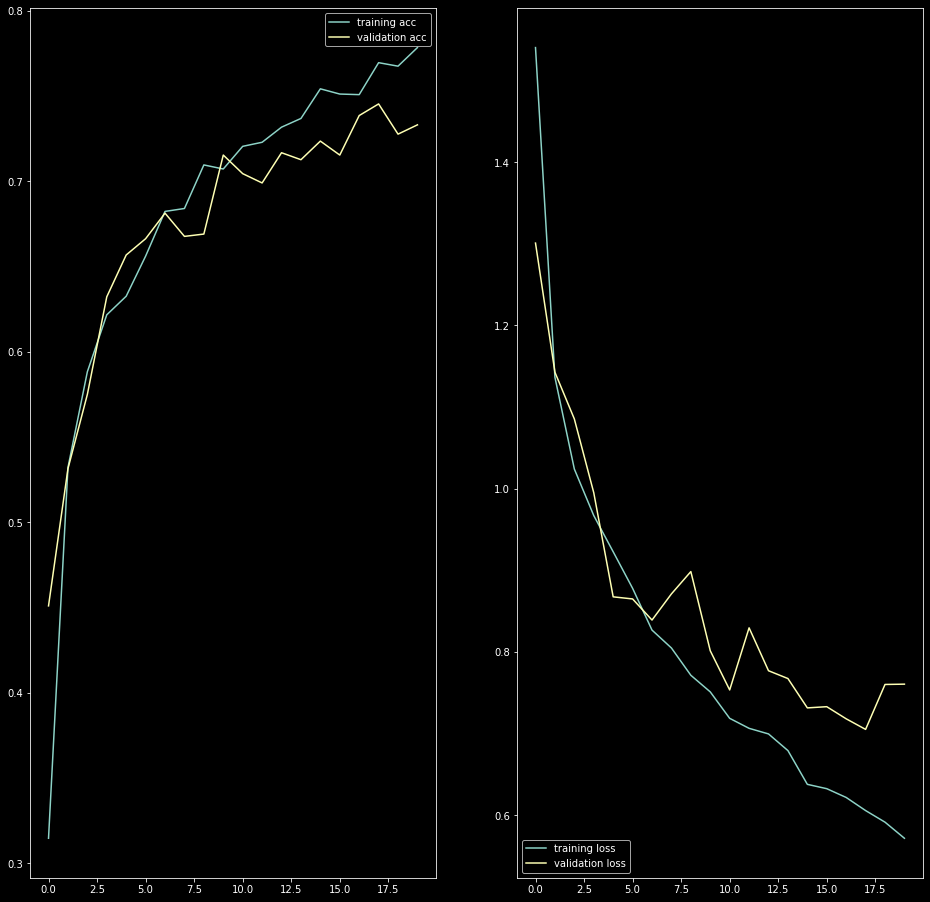

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)

#정확도 그래프
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'training acc')
plt.plot(epochs_range, val_acc, label=  'validation acc')
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'training loss')
plt.plot(epochs_range, val_loss, label = 'validation loss')
plt.legend(loc = 'lower left')

plt.show()